#I. **Importation du dossier**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/My Drive/datasets/dataset2.zip'
extraction_path = '/content/'

# Extraire le contenu du fichier ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Vérifier le contenu extrait
import os
print(os.listdir(extraction_path))


['.config', '__MACOSX', 'dataset2', 'drive', 'sample_data']


# II. **Description des données et objectif de travail**

Cet ensemble de données contient 12 500 images augmentées de cellules sanguines (JPEG) avec des étiquettes de type cellulaire (CSV) d'accompagnement. Il y a environ 3 000 images pour chacun de 4 types de cellules différents regroupées dans 4 dossiers différents (selon le type de cellule). Les types de cellules sont les éosinophiles, les lymphocytes, les monocytes et les neutrophiles. Cet ensemble de données est accompagné d'un ensemble de données supplémentaire contenant les 410 images originales (pré-augmentation) ainsi que deux étiquettes de sous-type supplémentaires (WBC vs WBC) et également de boîtes englobantes pour chaque cellule de chacune de ces 410 images (métadonnées JPEG + XML). Plus précisément, le dossier 'dataset-master' contient 410 images de cellules sanguines avec des étiquettes de sous-type et des boîtes englobantes (JPEG + XML), tandis que le dossier 'dataset2-master' contient 2 500 images augmentées ainsi que 4 étiquettes de sous-type supplémentaires (JPEG + CSV). Il y a environ 3 000 images augmentées pour chaque classe des 4 classes par rapport à 88, 33, 21 et 207 images de chacune dans le dossier 'dataset-master'.

Pour notre projet, nous avons choisi le dossier 'dataset2-master' renommé en 'dataset2' car il contient beaucoup plus d'images, par rapport au dossier 'dataset-master', ce qui est crucial pour entraîner un modèle de deep learning.

**Objectif**

Notre objectif est de concevoir un modèle de deep learning permettant de classifier avec précision les 4 catégories de cellules sanguines. Pour y parvenir, nous avons d'abord effectué un prétraitement des données, y compris la transformation des images, la gestion de l'augmentation des données et l'analyse de la distribution des classes. Ensuite, nous avons entraîné et évalué un CNN, ainsi qu'un modèle pré-entraîné ResNet50. Enfin, nous avons comparé leurs performances en appliquant différents classificateurs, tels que KNN, SVM et Random Forest, et visualisé les prédictions pour mieux interpréter les résultats.

#III. **Modèles**

# **Modèle CNN (Convolutional Neural Network)**

**Prétraitement et chargement des données**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
from PIL import Image

In [ ]:
# le modèle ne voit que des images trop "parfaites",
# donc il ne va pas générer de nouvelles images.
# alors nous ajoutons de la variabilité pour l'entraîner à mieux
# reconnaître les images sous différents angles.

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # nous augmentons la taille des images
    transforms.RandomRotation(15),  # nous faisons une rotation
    transforms.RandomHorizontalFlip(),  # nous faisons un flip horizontal
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# nos chemins pour les phases de test et d'entrainement
train_dir = "/content/dataset2/images/TRAIN"
test_dir = "/content/dataset2/images/TEST"

# chargement des données
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# création des chargeurs de données
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # augmentation de la taille du lot
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# batch_size=32 ->au lieu d’envoyer 1 image à la fois, on en envoie 32 en parallèle.
# shuffle=True-> mélange les images à chaque cycle pour que le modèle ne s’habitue pas à un ordre fixe.


classes = train_dataset.classes
# nous vérifions les differents types de classes :
# éosinophile, lymphocyte, monocyte, et neutrophile.
print(f"Classes détectées : {classes}")

Classes détectées : ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


**Distribution des classes**

<ipython-input-5-d60f6532f293>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()), ax=axes[0], palette="viridis")
<ipython-input-5-d60f6532f293>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(test_class_counts.keys()), y=list(test_class_counts.values()), ax=axes[1], palette="plasma")


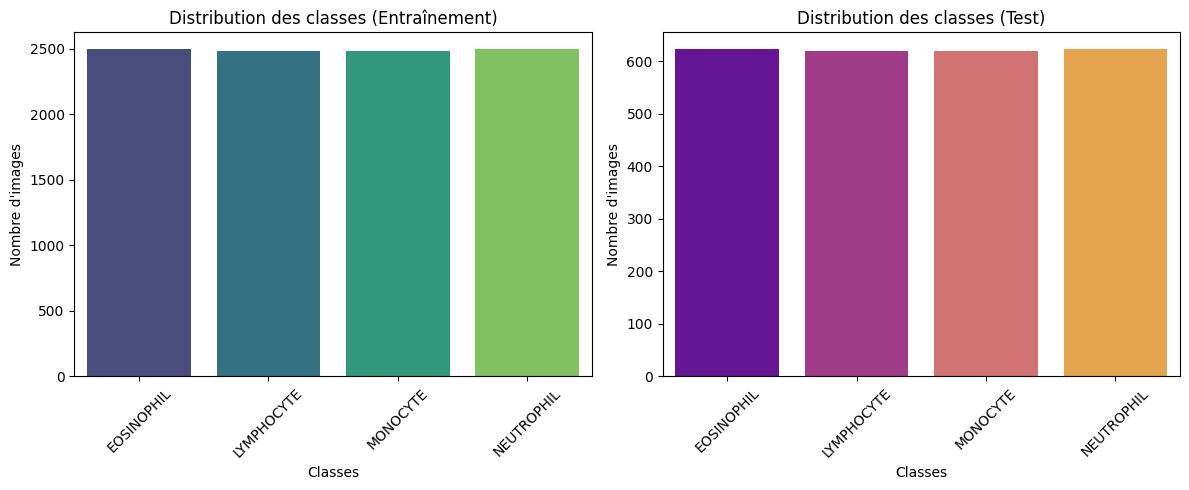

In [ ]:
import seaborn as sns
from collections import Counter
# récupération des labels de l'ensemble des données
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

# ici nous comptons des classes
train_class_counts = Counter(train_labels)
test_class_counts = Counter(test_labels)

# nous créons des graphiques
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# nousaffichons la distribution des classes pour l'ensemble d'entraînement
sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()), ax=axes[0], palette="viridis")
axes[0].set_title("Distribution des classes (Entraînement)")
axes[0].set_xlabel("Classes")
axes[0].set_ylabel("Nombre d'images")
axes[0].set_xticks(range(len(classes)))
axes[0].set_xticklabels(classes, rotation=45)

# nous affichons la distribution des classes pour l'ensemble de test
sns.barplot(x=list(test_class_counts.keys()), y=list(test_class_counts.values()), ax=axes[1], palette="plasma")
axes[1].set_title("Distribution des classes (Test)")
axes[1].set_xlabel("Classes")
axes[1].set_ylabel("Nombre d'images")
axes[1].set_xticks(range(len(classes)))
axes[1].set_xticklabels(classes, rotation=45)

#nous visualisons
plt.tight_layout()
plt.show()

**Création du modèle**

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # ce sont nos trois couches de convolutions :
        # conv1 trouve les bords et textures (petits détails),
        # conv2 trouve des formes plus complexes, et,
        # conv3 voit l’image complète.

        self.pool = nn.MaxPool2d(2, 2)
        # avec self.pool, nous réduisons progressivement la taille
        # de l’image pour garder les parties importantes.

        # Calcul automatique de la taille après convolutions
        self.flatten_size = self._get_flatten_size()

        self.fc1 = nn.Linear(self.flatten_size, 256)  # augmentation des neurones
        self.fc2 = nn.Linear(256, 4)  # 4 classes
        self.dropout = nn.Dropout(0.5)

        # fc1 -> convertit l’image "aplatie" en une série de chiffres.
        # fc2 -> donne 4 scores "un par classe".
        # dropout -> evite que le modèle apprenne trop par coeur.

    def _get_flatten_size(self):
        with torch.no_grad():
            sample_input = torch.zeros(1, 3, 128, 128)  #  correction ici
            x = self.pool(torch.relu(self.conv1(sample_input)))
            x = self.pool(torch.relu(self.conv2(x)))
            x = self.pool(torch.relu(self.conv3(x)))
            return x.numel()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def extract_features(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))  # cette couche est gardée pour extraire les caractéristiques.
        return x

# Nous initialisons le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# criterion -> compare la prédiction avec la vraie réponse.
# optimizer -> ajuste les poids du modèle pour améliorer les prédictions.

# nous entrainons avec suivi de la perte et de la précision
max_epochs = 100
target_accuracy = 99.0 #on a fait en sorte de s'arrêter a 99.0 de précision
epoch = 0
loss_history = []
accuracy_history = []

while epoch < max_epochs: #on a créer une boucle afin de rajouter des epochs
    running_loss = 0.0
    correct, total = 0, 0

    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)

    epoch += 1
    print(f"Epoch {epoch}, Perte: {epoch_loss:.4f}, Précision: {epoch_accuracy:.2f}%")

    if epoch_accuracy >= target_accuracy:
        print(f" Précision de {target_accuracy}% atteinte à l'epoch {epoch}")
        break

# nous affichons des courbes de perte et de précision
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Perte")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label="Précision")
plt.legend()
plt.show()

# l"évaluation du model
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Précision du modèle sur le test : {100 * correct / total:.2f}%")

# ici, nous testons sur une image unique
image_path = "dataset2/images/TEST/MONOCYTE/_0_1123.jpeg"

if os.path.exists(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    output = model(image)
    _, predicted = torch.max(output, 1)
    classe_predite = classes[predicted.item()]

    print(f"Classe prédite : {classe_predite}")
else:
    print("erreur")#si l'image n'existe pas on print "erreur"

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch 1, Perte: 1.0868, Précision: 49.39%
Epoch 2, Perte: 0.5644, Précision: 77.36%
Epoch 3, Perte: 0.3597, Précision: 85.79%
Epoch 4, Perte: 0.2529, Précision: 89.66%
Epoch 5, Perte: 0.2186, Précision: 91.32%
Epoch 6, Perte: 0.1681, Précision: 93.49%
Epoch 7, Perte: 0.1538, Précision: 94.25%
Epoch 8, Perte: 0.1323, Précision: 95.14%
Epoch 9, Perte: 0.1151, Précision: 95.81%


**Affichage d'image avec prédictions**

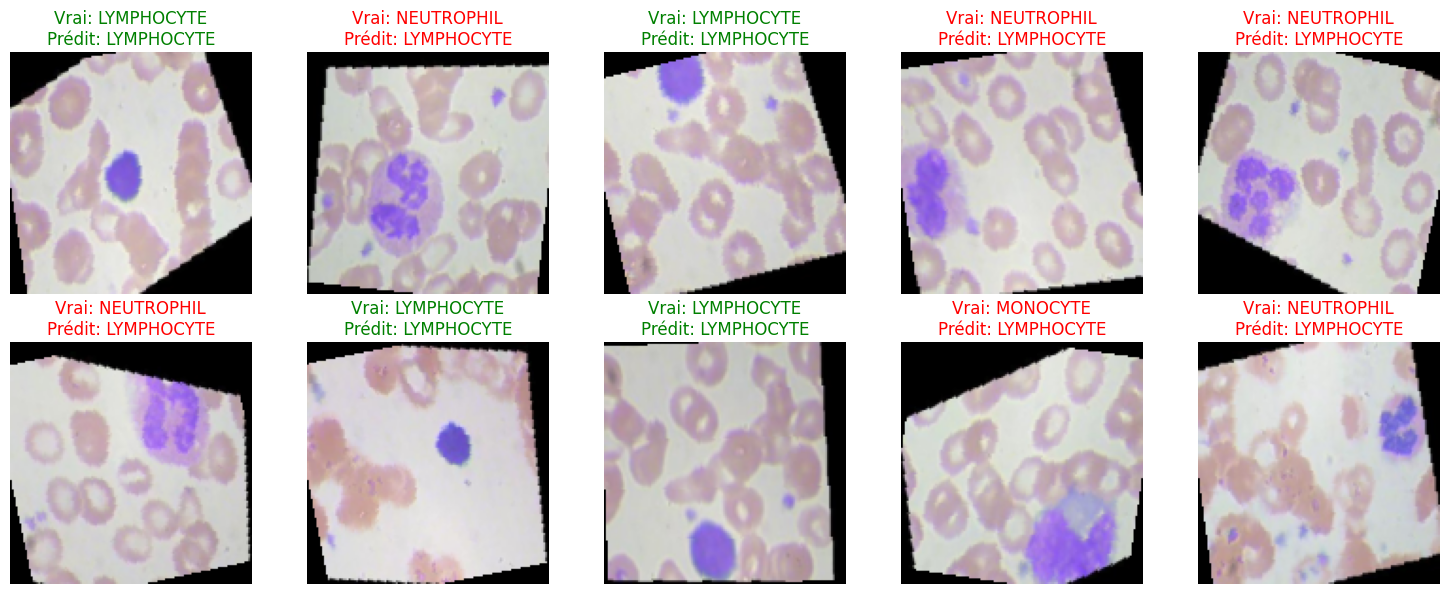

In [ ]:
#nous sélectionnons quelques images pour l'affichage
num_images = 10  # nombre d'images à afficher
indices = np.random.choice(len(test_loader.dataset), num_images, replace=False)

# grille 2x5 pour afficher les images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# boucle sur les indices choisis
for i, idx in enumerate(indices):
    image, true_label = test_loader.dataset[idx]
    image = image.unsqueeze(0).to(device)

    # prédiction
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)  # Prédiction de la classe

    # dénormalisation de l'image pour la rendre dans la plage [0, 1]
    image = image.squeeze(0)  # Enlever la dimension batch
    image = image * 0.5 + 0.5  # Dénormaliser les pixels

    # nous convertissons l'image de Tensor à NumPy pour l'affichage
    image = image.permute(1, 2, 0).cpu().numpy()

    # aaffichage de l'image
    axes[i].imshow(image)
    axes[i].axis("off")

    # couleur du texte (vert si prédiction correcte, rouge sinon)
    color = "green" if true_label == predicted else "red"
    axes[i].set_title(f"Vrai: {classes[true_label]}\nPrédit: {classes[predicted.item()]}", color=color)

plt.tight_layout()
plt.show()

# **Classificateurs du modèle CNN**

**KNN (K-Nearest Neighbors)**

In [ ]:
# chargement du modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

#nous désactivons l'apprentissage
model.eval()

# nous extrayons les caractérisques (features) du jeu d'entraînement :
train_features, train_labels = [], []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.numpy()
        features = model.extract_features(images).cpu().numpy()  # Extraction des features
        train_features.append(features)
        test_labels.extend(labels.cpu().numpy())

train_features = np.vstack(train_features)

# entraînement du modèle KNN
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
knn.fit(train_features, train_labels)

print("succès")

NameError: name 'torch' is not defined

In [ ]:
# nous extrayons les caractéristiques (features) du jeu de test :
test_features, test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.numpy()
        features = model.extract_features(images).cpu().numpy()  # Extraction des features
        test_features.append(features)
        train_labels.extend(labels.cpu().numpy())

test_features = np.vstack(test_features)

# prédictions avec KNN
predictions = knn.predict(test_features)

# affichage des métriques de classification
print("Classification Report:")
print(classification_report(test_labels, predictions, target_names=classes))

# matrice de confusion
conf_matrix = confusion_matrix(test_labels, predictions)
print("Matrice de Confusion:")
print(conf_matrix)

# affichage sous forme de heatmap ( carte thérmique)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de Confusion KNN")
plt.show()

Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.25      0.31      0.27       623
  LYMPHOCYTE       0.30      0.26      0.28       620
    MONOCYTE       0.27      0.25      0.26       620
  NEUTROPHIL       0.27      0.25      0.26       624

    accuracy                           0.27      2487
   macro avg       0.27      0.27      0.27      2487
weighted avg       0.27      0.27      0.27      2487

Matrice de Confusion:
[[194 157 132 140]
 [183 160 147 130]
 [201 106 157 156]
 [210 116 142 156]]


**Affichage des images avec prédictions**

In [ ]:
import matplotlib.pyplot as plt

# nous sélectionnons quelques images pour l'affichage
num_images = 10  # nombre d'images à afficher
indices = np.random.choice(len(test_features), num_images, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # grille 2x5 pour l'affichage
axes = axes.flatten()

for i, idx in enumerate(indices):
    image, true_label, predicted_label = test_dataset[idx][0], test_labels[idx], predictions[idx]

    # nous convertissonsl'image de Tensor à NumPy pour l'affichage
    image = image.permute(1, 2, 0).numpy()  # nous réorganisons les dimensions

    # affichage de l'image
    axes[i].imshow(image)
    axes[i].axis("off")

    # couleur du texte (vert si c'est vrai et rouge si c'est faux)
    color = "green" if true_label == predicted_label else "red"
    axes[i].set_title(f"Vrai: {classes[true_label]}\nPrédit: {classes[predicted_label]}", color=color)

plt.tight_layout()
plt.show()

**SVM (Support Vector Machine)**



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# entraînement du modèle
svm = SVC(kernel="linear", C=1.0)  #  SVM avec un noyau linéaire
svm.fit(train_features, train_labels)

# prédictions
pred_svm = svm.predict(test_features)

# évaluation du modèle
print("### SVM - Rapport de Classification ###")
print(classification_report(test_labels, pred_svm, target_names=classes))

# matrice de confusion
conf_matrix_svm = confusion_matrix(test_labels, pred_svm)

# affichage de la matrice de confusion sous forme de heatmap (carte thermique)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Matrice de Confusion - SVM")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()

### SVM - Rapport de Classification ###
              precision    recall  f1-score   support

  EOSINOPHIL       0.23      0.38      0.28       623
  LYMPHOCYTE       0.38      0.29      0.33       620
    MONOCYTE       0.41      0.11      0.18       620
  NEUTROPHIL       0.30      0.39      0.34       624

    accuracy                           0.29      2487
   macro avg       0.33      0.29      0.28      2487
weighted avg       0.33      0.29      0.28      2487



**Affichage des images avec prédictions**

In [ ]:
svm = SVC(kernel='linear')  # SVM avec un noyau linéaire
svm.fit(train_features, train_labels)

# prédictions
predictions_svm = svm.predict(test_features)

# nous sélectionnons quelques images pour l'affichage
num_images = 10  # nombre d'images à afficher
indices = np.random.choice(len(test_features), num_images, replace=False)

# aaffichage des images avec les prédictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # grille 2x5 pour l'affichage
axes = axes.flatten()

for i, idx in enumerate(indices):
    image, true_label, predicted_label = test_dataset[idx][0], test_labels[idx], predictions_svm[idx]

    # nous convertissons l'image de Tensor à NumPy pour l'affichage
    image = image.permute(1, 2, 0).numpy()  # nous réorganisons les dimensions

    # affichage de l'image
    axes[i].imshow(image)
    axes[i].axis("off")

    # couleur du texte (vert si c'est vrai et rouge si c'est faux)
    color = "green" if true_label == predicted_label else "red"
    axes[i].set_title(f"Vrai: {classes[true_label]}\nPrédit: {classes[predicted_label]}", color=color)

plt.tight_layout()
plt.show()

**Random Forest**

### Random Forest - Rapport de Classification ###
              precision    recall  f1-score   support

  EOSINOPHIL       0.23      0.27      0.25       623
  LYMPHOCYTE       0.32      0.31      0.32       620
    MONOCYTE       0.31      0.27      0.29       620
  NEUTROPHIL       0.29      0.28      0.28       624

    accuracy                           0.28      2487
   macro avg       0.29      0.28      0.29      2487
weighted avg       0.29      0.28      0.29      2487



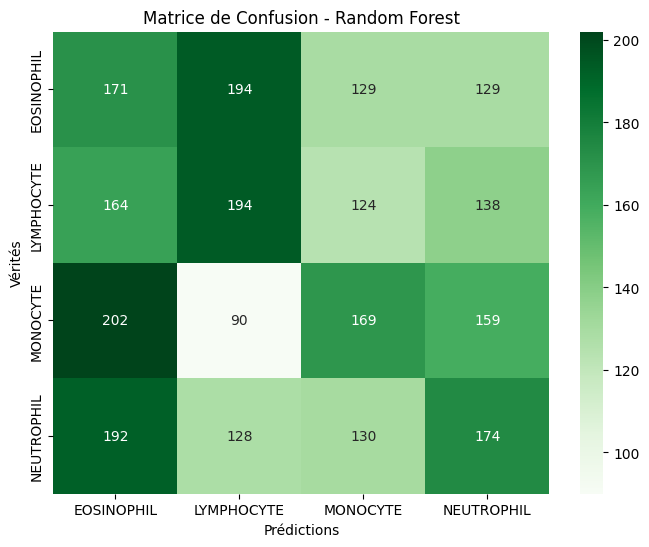

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# entraînement du modèle
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_features, train_labels)

# prédictions
pred_rf = rf.predict(test_features)

# évaluation du modèle
print("### Random Forest - Rapport de Classification ###")
print(classification_report(test_labels, pred_rf, target_names=classes))

# matrice de confusion
conf_matrix_rf = confusion_matrix(test_labels, pred_rf)

# affichage de la matrice de confusion sous forme de heatmap (carte thermique)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.title("Matrice de Confusion - Random Forest")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()

**Affichage des images avec prédictions**

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_features, train_labels)

# prédictions
predictions_rf = rf.predict(test_features)

# nous sélectionnons quelques images pour l'affichage
num_images = 10  # nombre d'images à afficher
indices = np.random.choice(len(test_features), num_images, replace=False)

# affichage des images avec les prédictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # grille 2x5 pour l'affichage
axes = axes.flatten()

for i, idx in enumerate(indices):
    image, true_label, predicted_label = test_dataset[idx][0], test_labels[idx], predictions_rf[idx]

    # nous convertissons l'image de Tensor à NumPy pour l'affichage
    image = image.permute(1, 2, 0).numpy()  # nous réorganisons les dimensions

    # affichage de l'image
    axes[i].imshow(image)
    axes[i].axis("off")

    # ccouleur du texte (vert si c'est vrai et rouge si c'est faux)
    color = "green" if true_label == predicted_label else "red"
    axes[i].set_title(f"Vrai: {classes[true_label]}\nPrédit: {classes[predicted_label]}", color=color)

plt.tight_layout()
plt.show()

# **Modèle ResNet18 (pré-entrainé)**

**Import et preparation des données**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
from collections import Counter
from sklearn.metrics import f1_score, recall_score, classification_report

# nous vérifions la présence du GPU ou CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# nous transformons les images avec augmentation des données
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# chargement des données
train_dir = "/content/dataset2/images/TRAIN"
test_dir = "/content/dataset2/images/TEST"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# nous créons un ensemble de validation (80% entrainement, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# nous affichons les infomations des classes et nous vérifions s'il y'a un déséquilibre entre eux
classes = train_dataset.dataset.classes
print(f"Classes détectées : {classes}")
train_counts = Counter(train_dataset.dataset.targets)
print(f"Distribution des classes : {train_counts}")

Classes détectées : ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
Distribution des classes : Counter({3: 2499, 0: 2497, 1: 2483, 2: 2478})


**Modèle**

In [ ]:
# si oui, nous gérons les classes déséquilibrées
class_counts = torch.tensor([train_counts[i] for i in range(len(classes))])
class_weights = 1.0 / class_counts.float()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# chargement du modèle
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# nous remplaçons la dernière couche (Fully Connected) pour adapter au nombre de classes
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Dropout(0.5), # # nous avons ajouter "Dropout" pour éviter le sur-apprentissage
    nn.Linear(num_ftrs, len(classes))
)
# nous envoyons le modèle sur GPU ou CPU
resnet18 = resnet18.to(device)

# optimiseur et scheduler
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# ici, nous avons les listes métriques
epochs = 5
loss_history, accuracy_history, val_loss_history, val_accuracy_history = [], [], [], []
val_recall_history, val_f1_history = [], []
train_recall_history, train_f1_history = [], []

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 62.8MB/s]


**Entrainement du modèle**

In [ ]:
for epoch in range(epochs):
    resnet18.train()
    running_loss, correct, total = 0.0, 0, 0
    train_all_preds = []
    train_all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_all_preds.extend(predicted.cpu().numpy())
        train_all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)

    train_recall = recall_score(train_all_labels, train_all_preds, average='macro')
    train_f1 = f1_score(train_all_labels, train_all_preds, average='macro')
    train_recall_history.append(train_recall)
    train_f1_history.append(train_f1)

    # ici, nous avons la validation
    resnet18.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_accuracy = 100 * val_correct / val_total
    val_recall = recall_score(all_labels, all_preds, average='macro')
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    val_loss_history.append(val_epoch_loss)
    val_accuracy_history.append(val_epoch_accuracy)
    val_recall_history.append(val_recall)
    val_f1_history.append(val_f1)

    scheduler.step(val_epoch_loss) # ici, nous ajustons le taux d'apprentissage

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Perte: {epoch_loss:.4f} | Précision: {epoch_accuracy:.2f}% | "
          f"Perte Validation: {val_epoch_loss:.4f} | Précision Validation: {val_epoch_accuracy:.2f}% | "
          f"Rappel: {val_recall:.4f} | F1: {val_f1:.4f}")

Epoch 1/5 | Perte: 0.4147 | Précision: 83.63% | Perte Validation: 0.7689 | Précision Validation: 78.11% | Rappel: 0.7787 | F1: 0.7771
Epoch 2/5 | Perte: 0.2181 | Précision: 92.09% | Perte Validation: 0.1327 | Précision Validation: 95.23% | Rappel: 0.9527 | F1: 0.9525
Epoch 3/5 | Perte: 0.1330 | Précision: 95.33% | Perte Validation: 0.1674 | Précision Validation: 94.23% | Rappel: 0.9423 | F1: 0.9425
Epoch 4/5 | Perte: 0.1127 | Précision: 95.64% | Perte Validation: 0.1303 | Précision Validation: 95.23% | Rappel: 0.9530 | F1: 0.9518
Epoch 5/5 | Perte: 0.1010 | Précision: 96.70% | Perte Validation: 0.1748 | Précision Validation: 94.83% | Rappel: 0.9497 | F1: 0.9481


**Courbes et evaluation sur le jeu de test**

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_history, label="Perte d'entraînement")
plt.plot(val_loss_history, label="Perte de validation")
plt.title("Courbe de Perte")
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(accuracy_history, label="Précision d'entraînement")
plt.plot(val_accuracy_history, label="Précision de validation")
plt.title("Courbe de Précision")
plt.xlabel("Époque")
plt.ylabel("Précision (%)")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_recall_history, label="Rappel d'entraînement", linestyle='--')
plt.plot(val_recall_history, label="Rappel de validation")
plt.title("Courbe de Rappel")
plt.xlabel("Époque")
plt.ylabel("Rappel")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_f1_history, label="F1-mesure d'entraînement", linestyle='--')
plt.plot(val_f1_history, label="F1-mesure de validation")
plt.title("Courbe de F1-mesure")
plt.xlabel("Époque")
plt.ylabel("F1-mesure")
plt.legend()

plt.tight_layout()
plt.show()

# iici, nous évaluons le modèle sur le jeu de test
resnet18.eval()
correct, total = 0, 0
test_preds, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print(f"Précision du modèle sur le test : {100 * correct / total:.2f}%")
print("Rapport de classification :\n")
print(classification_report(test_labels, test_preds, target_names=classes))

Précision du modèle sur le test : 84.84%
Rapport de classification :

              precision    recall  f1-score   support

  EOSINOPHIL       0.91      0.79      0.85       623
  LYMPHOCYTE       1.00      0.89      0.94       620
    MONOCYTE       0.91      0.79      0.84       620
  NEUTROPHIL       0.67      0.92      0.78       624

    accuracy                           0.85      2487
   macro avg       0.87      0.85      0.85      2487
weighted avg       0.87      0.85      0.85      2487



**Affichage de quelques images après prédictions**

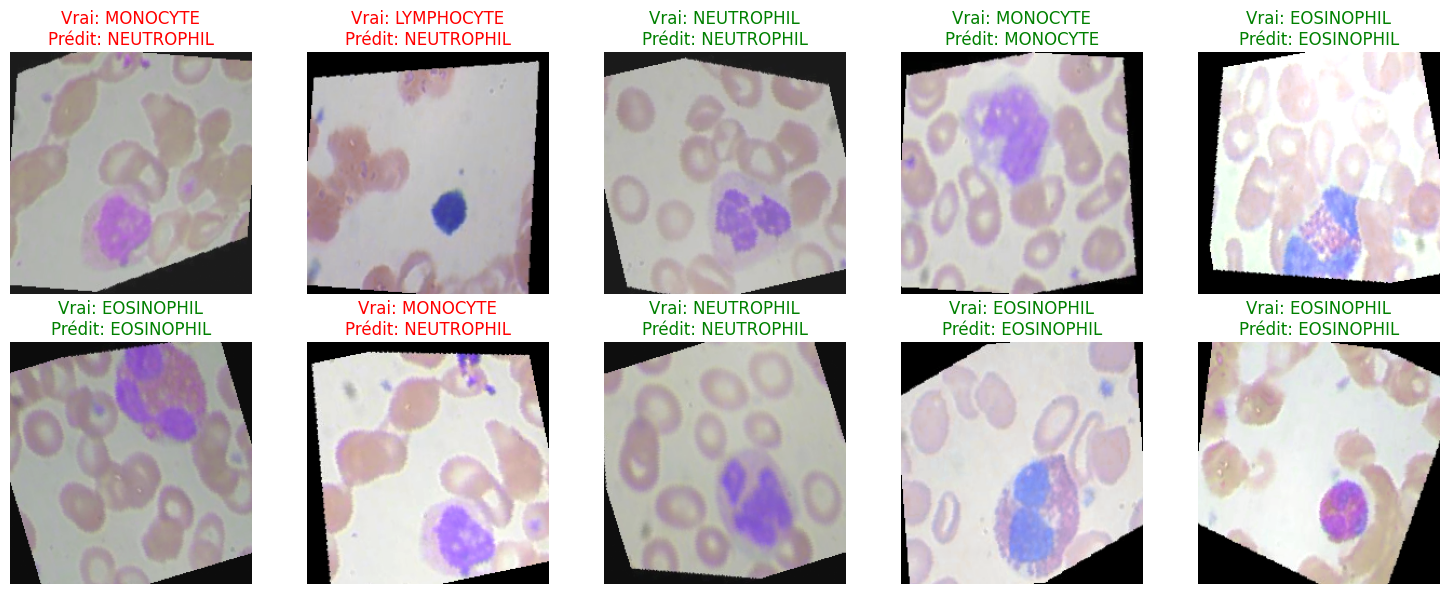

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ic, nous choisissons le nombres d'images à afficher
num_images = 10
indices = np.random.choice(len(test_loader.dataset), num_images, replace=False)

# ici, nous créons une grille 2x5
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# icii, nous mettons le modèle en mode évaluation
resnet18.eval()

# nous dénormalisons
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

for i, idx in enumerate(indices):
    image, true_label = test_loader.dataset[idx]
    input_image = image.unsqueeze(0).to(device)  # nous ajoutons dimension batch

    # prédiction
    with torch.no_grad():
        output = resnet18(input_image)
        _, predicted = torch.max(output, 1)

    image = image * std + mean # nous appliquons ici la dénormalisation
    image = image.clamp(0, 1).permute(1, 2, 0).numpy() # nous nous assurons que les valeurs sont entre 0 et 1
                                                       # et nous convertissons en format affichable
    # ici, nous affichons l'image
    axes[i].imshow(image)
    axes[i].axis("off")
    # couleur du texte : vert si c'est correct, rouge sinon
    color = "green" if predicted.item() == true_label else "red"
    axes[i].set_title(f"Vrai: {classes[true_label]}\nPrédit: {classes[predicted.item()]}", color=color)

plt.tight_layout()
plt.show()

# **Classificateurs du ResNet18 (approche basée sur les caractéristiques)**

**Préparation des données**

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ic, nous détectons le device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ici, nous faisons une transformation simple, pas d'augmentation
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# chargement des données
train_dir = "/content/dataset2/images/TRAIN"
test_dir = "/content/dataset2/images/TEST"

train_dataset_feat = datasets.ImageFolder(train_dir, transform=simple_transform)
test_dataset_feat = datasets.ImageFolder(test_dir, transform=simple_transform)

train_loader_feat = DataLoader(train_dataset_feat, batch_size=32, shuffle=False)
test_loader_feat = DataLoader(test_dataset_feat, batch_size=32, shuffle=False)

# ici, nous récupérons les classes
classes = train_dataset_feat.classes
print("Classes détectées :", classes)

Classes détectées : ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


**Extraction des caractéristiques à partir du modèle Resnet18**

In [ ]:
import numpy as np
from torchvision import models
from tqdm import tqdm

# ici, nous chargeons le modèle ResNet18 pré-entraîné
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18.fc = torch.nn.Identity()  # nous supprimons la dernière couche (Fully Connected)
resnet18 = resnet18.to(device)
resnet18.eval()

# ici, nous avons la fonction pour extraire les caractéristiques
def extract_features(dataloader):
    features, labels = [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Extraction des caractéristiques"):
            images = images.to(device)
            outputs = resnet18(images)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())

    return np.vstack(features), np.hstack(labels)

# nous extrayons sur entrainement et test
X_train, y_train = extract_features(train_loader_feat)
X_test, y_test = extract_features(test_loader_feat)

Extraction des caractéristiques: 100%|██████████| 78/78 [04:04<00:00,  3.13s/it]


**Entrainement des classificateurs : kNN, SVM et Random Forest**

Précision de KNN: 0.34


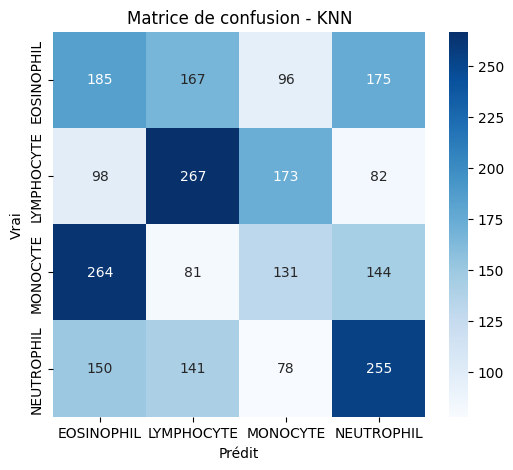

Précision de SVM: 0.46


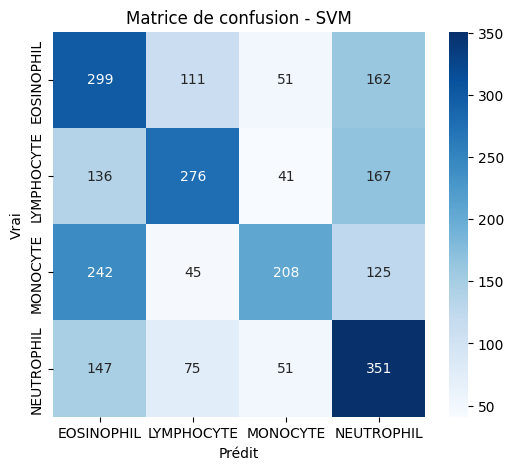

Précision de Random Forest: 0.36


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Entraînement des modèles
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel="linear", probability=True)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

knn.fit(X_train, y_train)
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)

# ici, nous evaluons et puis nous configurons les matrices de confusion
models = {"KNN": knn, "SVM": svm, "Random Forest": rf}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Précision de {name}: {acc:.2f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title(f"Matrice de confusion - {name}")
    plt.show()

**Affichage des images avec prédictions des classsificateurs**

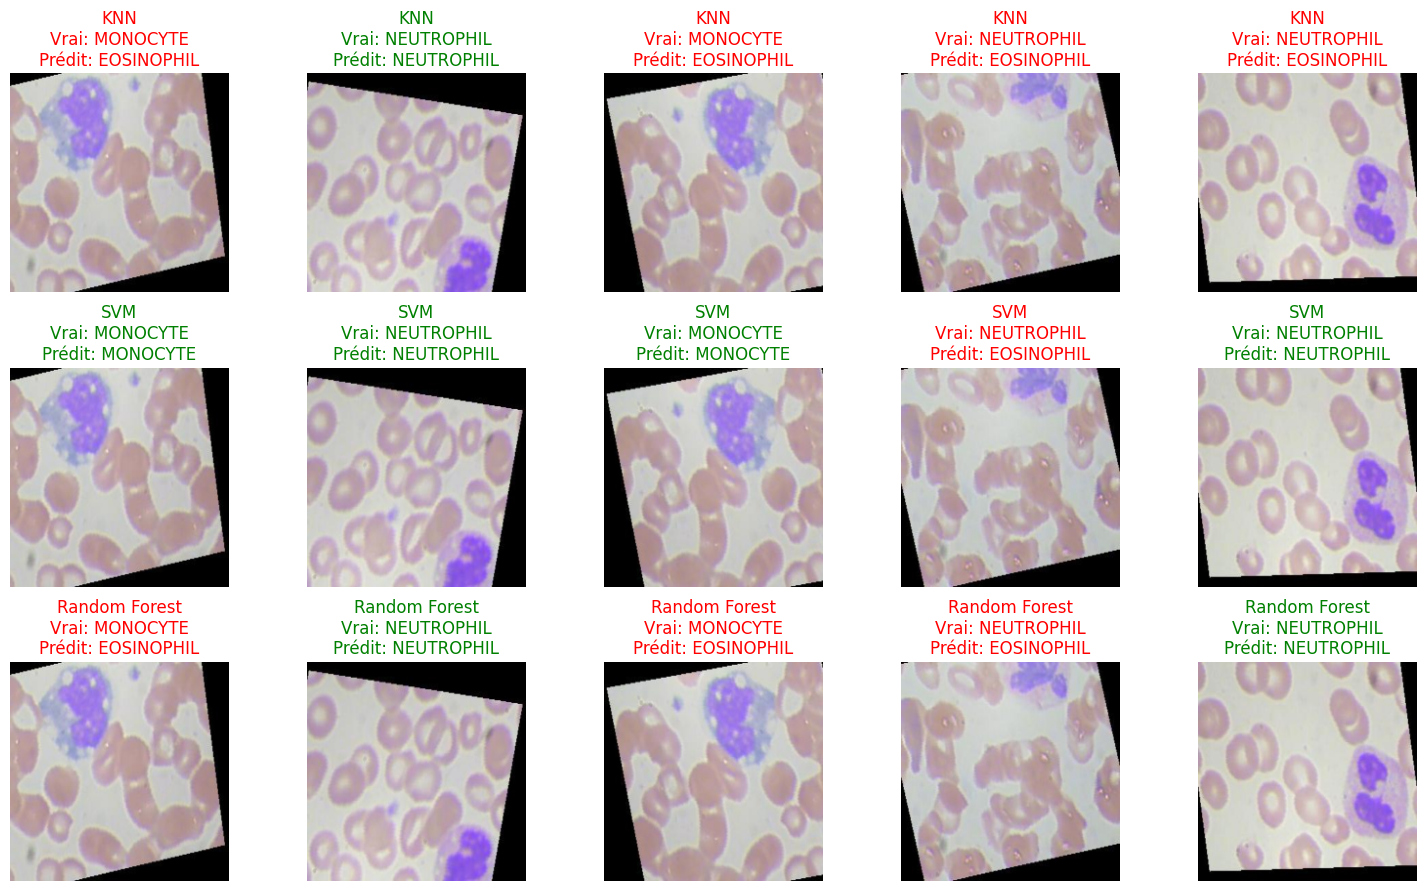

In [ ]:
import numpy as np

# ici, nous dénormalisons les images
def denormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (image_tensor * std + mean).clamp(0, 1)

# nous affichons les images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()
indices = np.random.choice(len(X_test), 5, replace=False)

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test[indices])

    for j, idx in enumerate(indices):
        image, true_label = test_dataset_feat[idx]
        image = denormalize(image)
        image = image.permute(1, 2, 0).numpy()

        axes[i * 5 + j].imshow(image)
        axes[i * 5 + j].axis("off")

        color = "green" if true_label == y_pred[j] else "red"
        axes[i * 5 + j].set_title(f"{name}\nVrai: {classes[true_label]}\nPrédit: {classes[y_pred[j]]}", color=color)

plt.tight_layout()
plt.show()

# **Modèle MLP ( Multi Layer Perceptron)**

**Imports et préparation des données**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# nous vérifions le device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Appareil utilisé :", device)

# nous appliquons des transformations pour le MLP
transform_mlp = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),  # Passage en niveaux de gris
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# chargement des données
train_dir = "/content/dataset2/images/TRAIN"
test_dir = "/content/dataset2/images/TEST"

train_dataset = datasets.ImageFolder(train_dir, transform=transform_mlp)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_mlp)

# ici, nous créons un ensemble de validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = train_dataset.dataset.classes
print("Classes :", classes)

Appareil utilisé : cpu
Classes : ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# nous vérifions la présence du GPU ou CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Appareil utilisé :", device)

# ici, nous faisons une transformation qui est spécifique pour ce modèle
transform_mlp = transforms.Compose([
    transforms.Resize((64, 64)),  # nous redimensionnons les images
    transforms.ToTensor()
])

# chargement des données
train_dir = "/content/dataset2/images/TRAIN"
test_dir = "/content/dataset2/images/TEST"

train_dataset = datasets.ImageFolder(train_dir, transform=transform_mlp)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_mlp)

# nous créons un ensemble de validation (80% entrainement, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ici, nous affichons les classes
classes = train_dataset.dataset.classes
print("Classes :", classes)

Appareil utilisé : cpu
Classes : ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


**Définition du modèle**

In [ ]:
class OptimizedMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(OptimizedMLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # nous applatissons l’image
        return self.fc(x)

# ici, nous déterminons la taille d'entrée
sample_input = next(iter(train_loader))[0]
input_size = sample_input[0].numel()  # 1 x 32 x 32 = 1024

model = OptimizedMLP(input_size=input_size, num_classes=len(classes)).to(device)

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # ici, nous applatissons
        return self.fc(x)

# ici, nous calculons la taille d'entrée (C x H x W)
sample_input = next(iter(train_loader))[0]
input_size = sample_input[0].numel()

model = SimpleMLP(input_size=input_size, num_classes=len(classes)).to(device)

**Entrainement du modèle**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []
train_f1_history, val_f1_history = [], []
train_recall_history, val_recall_history = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    train_recall = recall_score(all_labels, all_preds, average='macro')

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    train_f1_history.append(train_f1)
    train_recall_history.append(train_recall)

    # la validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss_epoch = val_loss / len(val_loader)
    val_acc_epoch = 100 * val_correct / val_total
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_recall = recall_score(val_labels, val_preds, average='macro')

    val_loss_history.append(val_loss_epoch)
    val_acc_history.append(val_acc_epoch)
    val_f1_history.append(val_f1)
    val_recall_history.append(val_recall)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Perte d'entrainement : {train_loss:.4f}, Précision: {train_acc:.2f}%, F1-mesure: {train_f1:.4f}, Rappel: {train_recall:.4f} | "
          f"Perte de validation: {val_loss_epoch:.4f}, Précision: {val_acc_epoch:.2f}%, F1-mesure: {val_f1:.4f}, Rappel: {val_recall:.4f}")

print("Entraînement terminé !")

Epoch 1/5, Perte d'entrainement : 1.3988, Précision: 29.03%, F1-mesure: 0.2875, Rappel: 0.2906 | Perte de validation: 1.3599, Précision: 32.88%, F1-mesure: 0.3009, Rappel: 0.3281
Epoch 2/5, Perte d'entrainement : 1.3629, Précision: 31.14%, F1-mesure: 0.3074, Rappel: 0.3116 | Perte de validation: 1.3395, Précision: 32.08%, F1-mesure: 0.2982, Rappel: 0.3196
Epoch 3/5, Perte d'entrainement : 1.3363, Précision: 33.57%, F1-mesure: 0.3331, Rappel: 0.3360 | Perte de validation: 1.3222, Précision: 33.79%, F1-mesure: 0.3116, Rappel: 0.3358
Epoch 4/5, Perte d'entrainement : 1.3172, Précision: 34.92%, F1-mesure: 0.3440, Rappel: 0.3497 | Perte de validation: 1.2994, Précision: 36.45%, F1-mesure: 0.3515, Rappel: 0.3626
Epoch 5/5, Perte d'entrainement : 1.2992, Précision: 37.04%, F1-mesure: 0.3636, Rappel: 0.3710 | Perte de validation: 1.2812, Précision: 37.50%, F1-mesure: 0.3687, Rappel: 0.3740
Entraînement terminé !


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []
train_f1_history, val_f1_history = [], []
train_recall_history, val_recall_history = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    train_recall = recall_score(all_labels, all_preds, average='macro')

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    train_f1_history.append(train_f1)
    train_recall_history.append(train_recall)

    # la validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss_epoch = val_loss / len(val_loader)
    val_acc_epoch = 100 * val_correct / val_total
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_recall = recall_score(val_labels, val_preds, average='macro')

    val_loss_history.append(val_loss_epoch)
    val_acc_history.append(val_acc_epoch)
    val_f1_history.append(val_f1)
    val_recall_history.append(val_recall)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Perte d'entrainement : {train_loss:.4f}, Précision: {train_acc:.2f}%, F1-mesure: {train_f1:.4f}, Rappel: {train_recall:.4f} | "
          f"Perte de validation: {val_loss_epoch:.4f}, Précision: {val_acc_epoch:.2f}%, F1-mesure: {val_f1:.4f}, Rappel: {val_recall:.4f}")

print("Entraînement terminé !")

Epoch 1/5, Perte d'entrainement : 1.5185, Précision: 24.60%, F1-mesure: 0.2351, Rappel: 0.2456 | Perte de validation: 1.3865, Précision: 25.60%, F1-mesure: 0.1019, Rappel: 0.2500
Epoch 2/5, Perte d'entrainement : 1.3865, Précision: 24.98%, F1-mesure: 0.1824, Rappel: 0.2479 | Perte de validation: 1.3865, Précision: 24.20%, F1-mesure: 0.0974, Rappel: 0.2500
Epoch 3/5, Perte d'entrainement : 1.3864, Précision: 24.63%, F1-mesure: 0.1979, Rappel: 0.2452 | Perte de validation: 1.3864, Précision: 24.20%, F1-mesure: 0.0974, Rappel: 0.2500
Epoch 4/5, Perte d'entrainement : 1.3863, Précision: 25.52%, F1-mesure: 0.1606, Rappel: 0.2529 | Perte de validation: 1.3865, Précision: 24.20%, F1-mesure: 0.0974, Rappel: 0.2500
Epoch 5/5, Perte d'entrainement : 1.3863, Précision: 25.36%, F1-mesure: 0.1614, Rappel: 0.2512 | Perte de validation: 1.3865, Précision: 24.20%, F1-mesure: 0.0974, Rappel: 0.2500
Entraînement terminé !


**Visualisation des courbes**

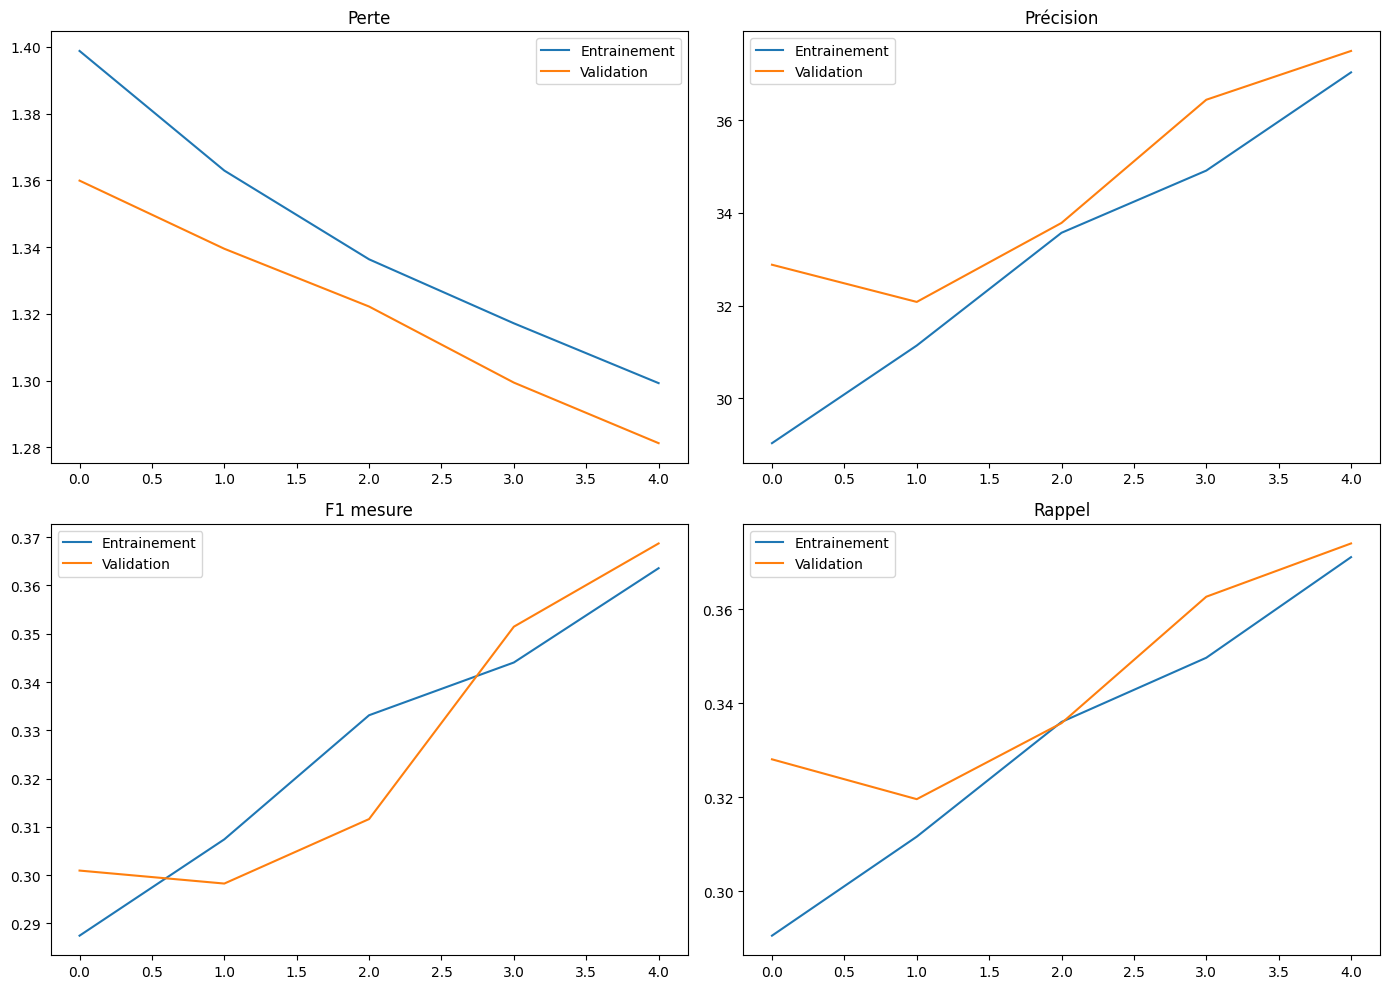

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(train_loss_history, label="Entrainement")
plt.plot(val_loss_history, label="Validation")
plt.title("Perte")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_acc_history, label="Entrainement")
plt.plot(val_acc_history, label="Validation")
plt.title("Précision")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_f1_history, label="Entrainement")
plt.plot(val_f1_history, label="Validation")
plt.title("F1 mesure")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_recall_history, label="Entrainement")
plt.plot(val_recall_history, label="Validation")
plt.title("Rappel")
plt.legend()

plt.tight_layout()
plt.show()

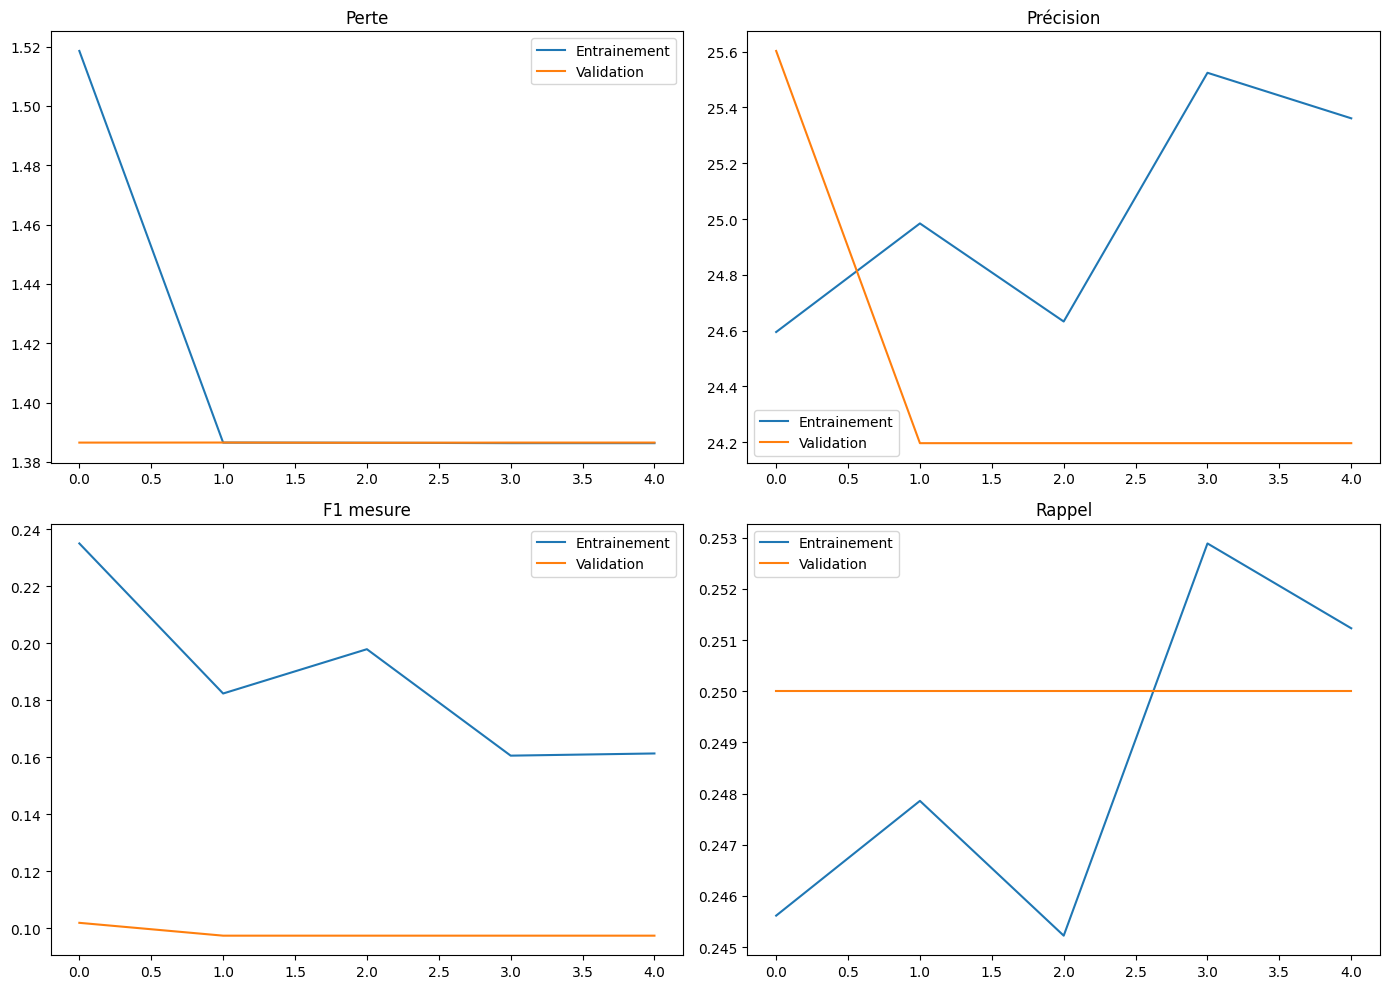

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(train_loss_history, label="Entrainement")
plt.plot(val_loss_history, label="Validation")
plt.title("Perte")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_acc_history, label="Entrainement")
plt.plot(val_acc_history, label="Validation")
plt.title("Précision")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_f1_history, label="Entrainement")
plt.plot(val_f1_history, label="Validation")
plt.title("F1 mesure")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_recall_history, label="Entrainement")
plt.plot(val_recall_history, label="Validation")
plt.title("Rappel")
plt.legend()

plt.tight_layout()
plt.show()

**Evaluation du modèle sur le jeu de test**

In [ ]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Précision finale sur le test : {100 * correct / total:.2f}%")

Précision finale sur le test : 27.18%


In [ ]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Précision finale sur le test : {100 * correct / total:.2f}%")

Précision finale sur le test : 25.05%


**Affichage des images testées avec la prédiction**

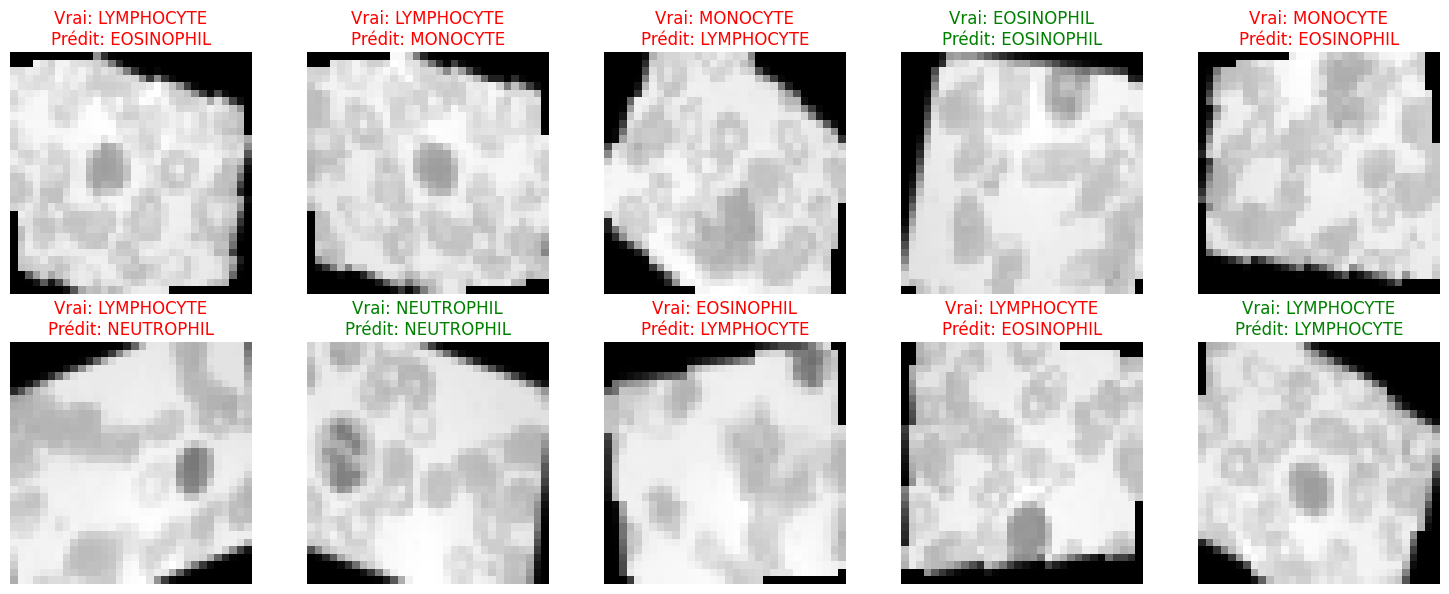

In [ ]:
num_images = 10
indices = np.random.choice(len(test_loader.dataset), num_images, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

model.eval()

for i, idx in enumerate(indices):
    image, true_label = test_loader.dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
        _, predicted = torch.max(output, 1)

    image_disp = image.squeeze().numpy()
    image_disp = np.clip((image_disp * 0.5 + 0.5), 0, 1)

    axes[i].imshow(image_disp, cmap="gray")
    axes[i].axis("off")

    color = "green" if true_label == predicted.item() else "red"
    axes[i].set_title(f"Vrai: {classes[true_label]}\nPrédit: {classes[predicted.item()]}", color=color)

plt.tight_layout()
plt.show()

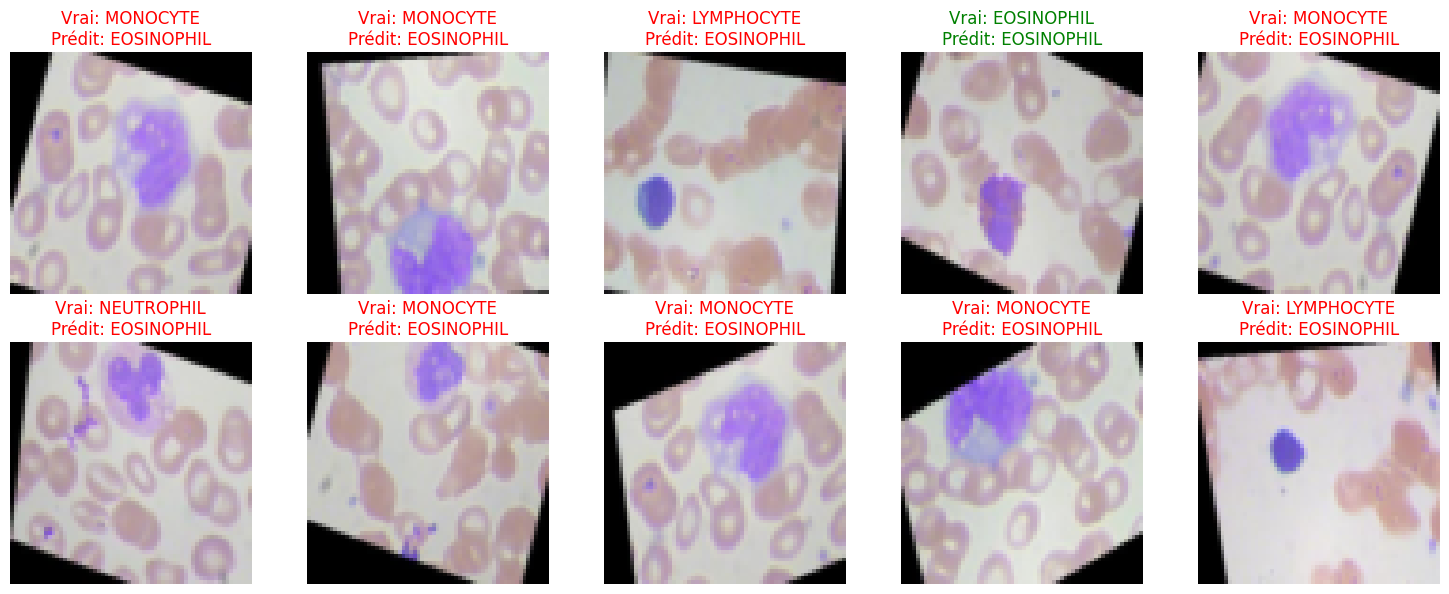

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ici, nous sélectionnons quelques indices aléatoires
num_images = 10
indices = np.random.choice(len(test_loader.dataset), num_images, replace=False)

# nous créons une grille d'affichage
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# nous faisons passer le modèle en mode évaluation
model.eval()

for i, idx in enumerate(indices):
    image, true_label = test_loader.dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
        _, predicted = torch.max(output, 1)

    # ici, l'image est déjà en format [0, 1], nous la remettons en forme pour l'affichage
    image_disp = image.permute(1, 2, 0).numpy()
    image_disp = np.clip(image_disp, 0, 1)

    axes[i].imshow(image_disp)
    axes[i].axis("off")

    color = "green" if true_label == predicted.item() else "red"
    axes[i].set_title(f"Vrai: {classes[true_label]}\nPrédit: {classes[predicted.item()]}", color=color)

plt.tight_layout()
plt.show()

# **Classificateurs du MLP (approche basée sur les caractéristiques)**

**Extraction des caractéristiques**

In [ ]:
# ici, nous apportons des modifiations au modèle pour obtenir les caractéristiques avant la dernière couche
class SimpleMLPFeatureExtractor(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleMLPFeatureExtractor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)  # nous conserverons la dernière couche pour la sortie
        )
        self.features = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
        )  # c'est cette partie qui nous donne les caractéristiques avant la dernière couche

    def forward(self, x):
        features = self.features(x.view(x.size(0), -1))  # ici, nous applatissons et obtenons les caractéristiques
        return features

# nous initialisons le modèle
mlp_feature_extractor = SimpleMLPFeatureExtractor(input_size=input_size, num_classes=len(classes)).to(device)

In [ ]:
def extract_mlp_features(dataloader):
    features, labels = [], []

    mlp_feature_extractor.eval()  # nous mettons le modèle en mode évaluation
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Extraction des caractéristiques MLP"):
            images, targets = images.to(device), targets.to(device)
            features_output = mlp_feature_extractor(images)
            features.append(features_output.cpu().numpy())
            labels.append(targets.cpu().numpy())

    return np.vstack(features), np.hstack(labels)

# icii, nous extrayons les caractéristiques pour l'entraînement et le test
X_train, y_train = extract_mlp_features(train_loader)
X_test, y_test = extract_mlp_features(test_loader)

Extraction des caractéristiques MLP: 100%|██████████| 39/39 [00:06<00:00,  5.70it/s]


**Entrainement des classificateurs : kNN, SVM et Random Forest**

Précision de KNN: 0.26


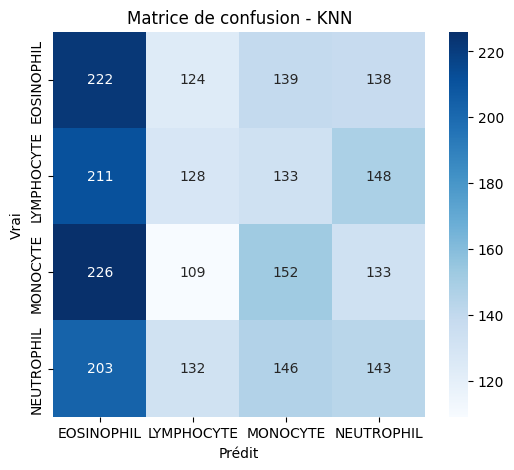

Précision de SVM: 0.29


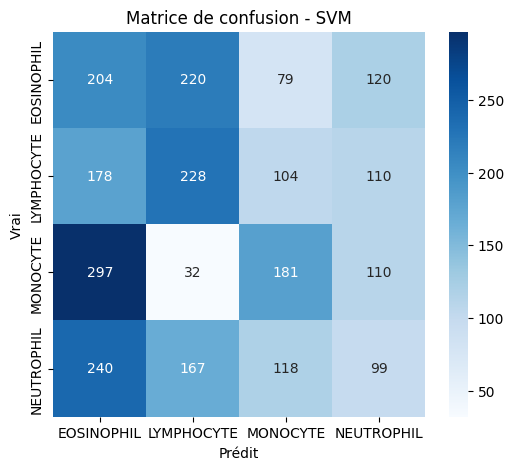

Précision de Random Forest: 0.27


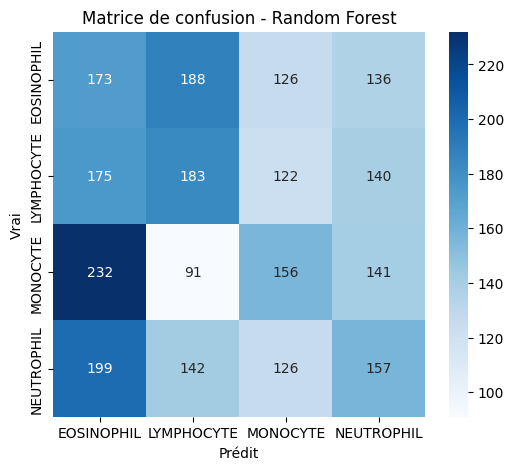

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# nous initialisons les classificateurs
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel="linear", probability=True)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# nous entraînons les classificateurs
knn.fit(X_train, y_train)
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)

# nous évaluons les modèles
models = {"KNN": knn, "SVM": svm, "Random Forest": rf}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Précision de {name}: {acc:.2f}")

    # nous affichons la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title(f"Matrice de confusion - {name}")
    plt.show()

**Affichage des images avec les prédictions**

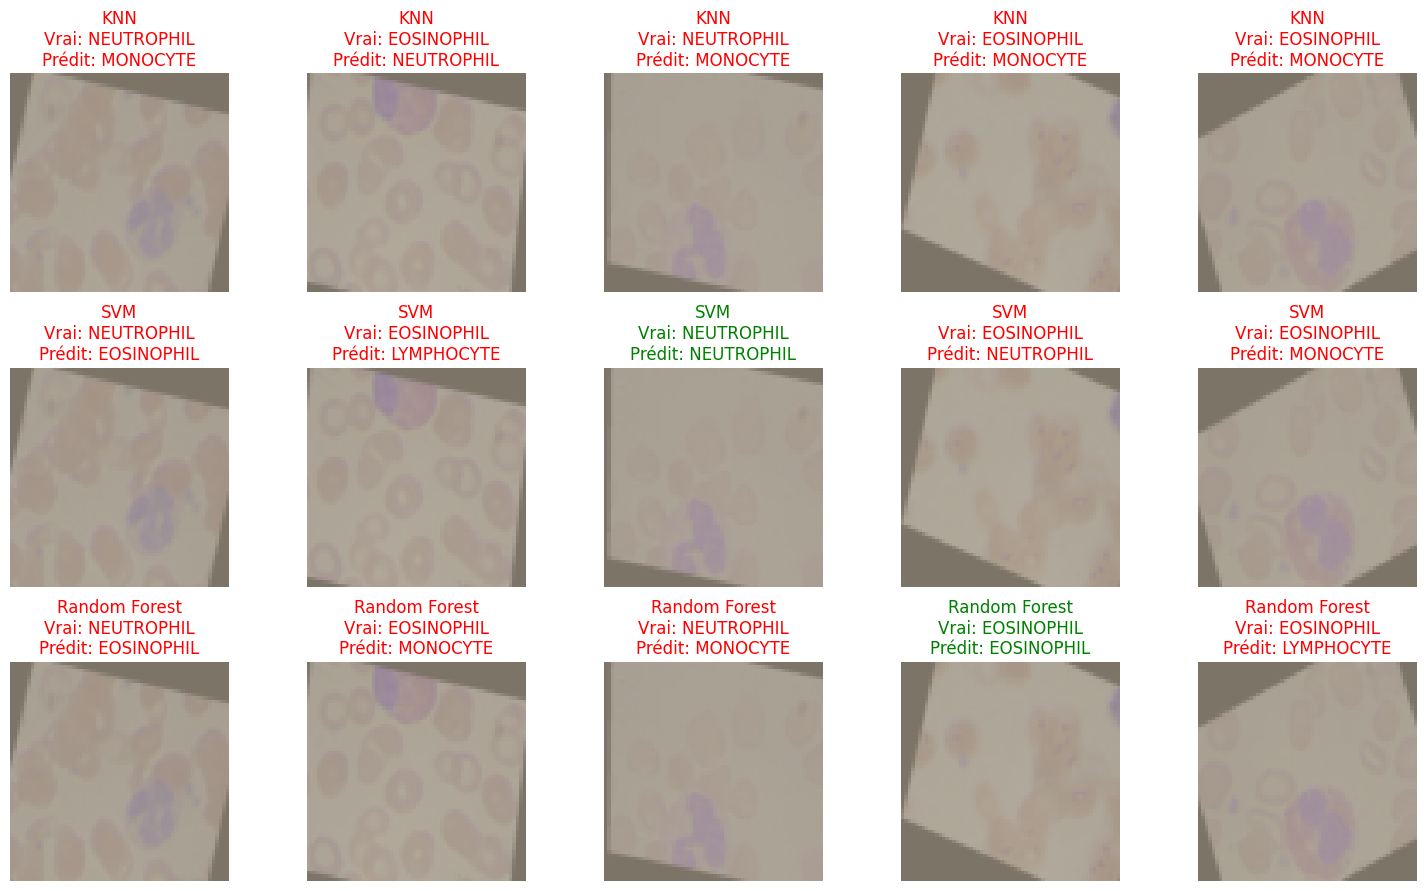

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 classificateurs, 5 images
axes = axes.flatten()
indices = np.random.choice(len(X_test), 5, replace=False)

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test[indices])  # les prédictions sur les images sélectionnées

    for j, idx in enumerate(indices):
        image, true_label = test_dataset[idx]  # nous récupérons l'image
        image = image * std + mean  # nous dénormalisons
        image = image.clamp(0, 1)  # nous nous assurons que les valeurs sont entre 0 et 1
        image = image.permute(1, 2, 0).numpy()  # nous convertissons en format affichable

        axes[i * 5 + j].imshow(image)
        axes[i * 5 + j].axis("off")

        # la couleur du texte: verte si c'est correcte, rouge sinon
        color = "green" if true_label == y_pred[j] else "red"
        axes[i * 5 + j].set_title(f"{name}\nVrai: {classes[true_label]}\nPrédit: {classes[y_pred[j]]}", color=color)

plt.tight_layout()
plt.show()